In [58]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import talib
from reflame import MhaFlnnRegressor

In [59]:
# Step 1: Data Retrieval and Preparation
ticks = ["TUPRS.IS"]
df_list = []

for tick in ticks:
    df = yf.download(tick, start=pd.to_datetime('today') - timedelta(400), interval='60m')
    df['Ticker'] = tick  # Label each ticker
    df_list.append(df)

df = pd.concat(df_list, axis=0)  # Combine data for all tickers

[*********************100%***********************]  1 of 1 completed


In [60]:
# Ensure 'Close' and 'Volume' columns are of type float64
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(float)

# Step 2: Calculation of Technical Indicators

# Calculate RSI (Relative Strength Index)
df['RSI'] = talib.RSI(df['Close'].values.flatten(), timeperiod=14)

# Calculate MAVI (Moving Average Volume Indicator)
df['Short_MA'] = talib.SMA(df['Volume'].values.flatten(), timeperiod=5)
df['Long_MA'] = talib.SMA(df['Volume'].values.flatten(), timeperiod=20)
df['MAVI'] = df['Short_MA'] / df['Long_MA']

In [61]:
# Step 3: Filling Missing Data

# Checking for missing values in each column
missing_counts = df.isnull().sum()

# Displaying the count of missing values
print(missing_counts)

Price      Ticker  
Adj Close  TUPRS.IS     0
Close      TUPRS.IS     0
High       TUPRS.IS     0
Low        TUPRS.IS     0
Open       TUPRS.IS     0
Volume     TUPRS.IS     0
Ticker                  0
RSI                    14
Short_MA                4
Long_MA                19
MAVI                   19
dtype: int64


In [62]:
# Handling Missing Data with Interpolation

# Filling missing values using linear interpolation
df.interpolate(method='linear', inplace=True)

# Filling any remaining missing values forward and backward
df.ffill(inplace=True)  # Forward fill
df.bfill(inplace=True)  # Backward fill

# Checking to confirm no missing values remain
print(df.isnull().sum())


Price      Ticker  
Adj Close  TUPRS.IS    0
Close      TUPRS.IS    0
High       TUPRS.IS    0
Low        TUPRS.IS    0
Open       TUPRS.IS    0
Volume     TUPRS.IS    0
Ticker                 0
RSI                    0
Short_MA               0
Long_MA                0
MAVI                   0
dtype: int64


C:\Users\Berkay\AppData\Local\Temp\ipykernel_5552\1887766667.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [63]:
# Step 4: Defining Independent and Dependent Variables

# Selecting independent variables
X = df[['Open', 'RSI', 'MAVI', 'Long_MA']]

# Defining the dependent variable
y = df['Adj Close']

In [64]:
# Step 5: Splitting Data into Training and Testing Sets (80% Training, 20% Testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# Step 6: Scaling Data (Using MinMaxScaler to scale between 0 and 1)
scaler_X = MinMaxScaler(feature_range=(0, 1))  # MinMaxScaler for X
scaler_y = MinMaxScaler(feature_range=(0, 1))  # MinMaxScaler for y

# Scaling training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Scaling test data (fit applied only to training set)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [66]:
# Define parameters for optimization and model settings
# FFA (Firefly Algorithm) is used here as the optimization method
opt_paras = {"name": "FFA", "epoch": 20, "pop_size": 70}

# Initialize the model with specified settings
model = MhaFlnnRegressor(
    expand_name="legendre",  # Legendre polynomial expansion for feature enhancement 
    n_funcs=3,
    act_name="relu",
    obj_name="RMSE",
    optimizer="OriginalFFA",  # Firefly Algorithm as the optimizer
    optimizer_paras=opt_paras,
    verbose=True
)

In [67]:
# Step 7: Train the model
model.fit(X_train_scaled, y_train_scaled)

2024/11/04 04:45:53 AM, INFO, mealpy.swarm_based.FFA.OriginalFFA: Solving single objective optimization problem.
2024/11/04 04:46:04 AM, INFO, mealpy.swarm_based.FFA.OriginalFFA: >>>Problem: P, Epoch: 1, Current best: 0.12568974336128833, Global best: 0.12568974336128833, Runtime: 10.64532 seconds
2024/11/04 04:46:14 AM, INFO, mealpy.swarm_based.FFA.OriginalFFA: >>>Problem: P, Epoch: 2, Current best: 0.12568974336128833, Global best: 0.12568974336128833, Runtime: 10.45364 seconds
2024/11/04 04:46:25 AM, INFO, mealpy.swarm_based.FFA.OriginalFFA: >>>Problem: P, Epoch: 3, Current best: 0.12568974336128833, Global best: 0.12568974336128833, Runtime: 10.25715 seconds
2024/11/04 04:46:35 AM, INFO, mealpy.swarm_based.FFA.OriginalFFA: >>>Problem: P, Epoch: 4, Current best: 0.12568974336128833, Global best: 0.12568974336128833, Runtime: 10.38749 seconds
2024/11/04 04:46:45 AM, INFO, mealpy.swarm_based.FFA.OriginalFFA: >>>Problem: P, Epoch: 5, Current best: 0.12445864445332208, Global best: 0.12

MhaFlnnRegressor(act_name='relu', expand_name='legendre', n_funcs=3,
                 obj_name='RMSE',
                 optimizer=<mealpy.swarm_based.FFA.OriginalFFA object at 0x00000190CDEE6250>,
                 optimizer_paras={'epoch': 20, 'name': 'FFA', 'pop_size': 70},
                 verbose=True)

In [68]:
# Step 8: Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

In [69]:
# Step 9: Inverse scaling of predicted values (return to original scale)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

In [70]:
# Step 10: Evaluate model performance
rmse = model.score(X=X_test_scaled, y=y_test_scaled, method="RMSE")
metrics = model.scores(X=X_test_scaled, y=y_test_scaled, list_methods=["R2", "NSE", "MAPE", "MAE"])

In [71]:
# Step 11: Display Results
print("Results:")
print(f" - RMSE: {rmse}")

# Display additional metrics
additional_metrics = model.evaluate(y_true=y_test_scaled, y_pred=y_pred_scaled, list_metrics=["R2", "NSE", "MAPE", "NNSE", "MAE"]) 
print("Additional Metrics:")
for metric, value in additional_metrics.items():
    # Show MAPE as a percentage
    if metric == "MAPE":
        print(f" - {metric}: {value * 100:.2f}%")
    else:
        print(f" - {metric}: {value}")

Results:
 - RMSE: 0.07539624063940698
Additional Metrics:
 - R2: 0.849202231521006
 - NSE: 0.849202231521006
 - MAPE: 21.90%
 - NNSE: 0.8689624079838953
 - MAE: 0.0601651724841134


In [72]:
# Step 12: Generate Buy/Sell/Hold points based on FLANN model predictions
def generate_buy_sell_hold_points(predictions, real_prices, threshold=0.01):
    buy_sell_hold = []
    
    for i in range(1, len(predictions)):
        prev_price = real_prices[i - 1]
        predicted_price = predictions[i]
        
        # If predicted price is 1% higher than the previous close, signal 'Buy'
        if predicted_price > prev_price * (1 + threshold):
            buy_sell_hold.append("Buy")
        
        # If predicted price is 1% lower than the previous close, signal 'Sell'
        elif predicted_price < prev_price * (1 - threshold):
            buy_sell_hold.append("Sell")
        
        # If difference is within 1%, signal 'Hold'
        else:
            buy_sell_hold.append("Hold")
    
    return buy_sell_hold

# Get actual prices (original test set values)
real_prices = y_test.values

# Generate Buy/Sell/Hold decisions based on FLANN model outputs
buy_sell_hold_points = generate_buy_sell_hold_points(y_pred, real_prices)

# Print the results
print(buy_sell_hold_points)

['Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Sell', 'Hold', 'Buy', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Sell', 'Sell', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Hold', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Buy', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Hold', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Sell', 'Sell', 'Buy', 'Sell', 'Buy', 'Hold', 'Buy', 'Sell', 'Buy', 'Buy', 'Sell', 'Hold', 'Sell', 'Buy', 'Hold', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Buy', 'Sell', 'Sell', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Buy', 'Sell', 'Sell', 'Buy', 'Sell', 'B

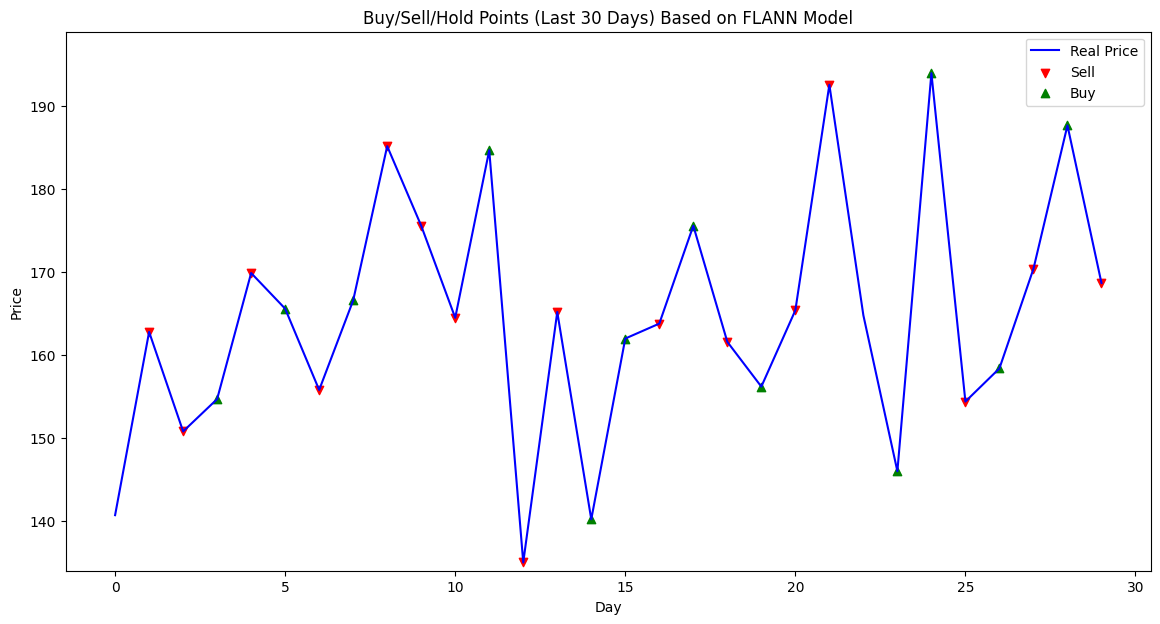

In [73]:
# Plotting the Buy/Sell/Hold points on the real price data for the last 30 days

def plot_buy_sell_hold(real_prices, buy_sell_hold_points):
    plt.figure(figsize=(14,7))
    plt.plot(real_prices[-30:], label="Real Price", color="blue")  # Last 30 days of real prices

    # Display Buy and Sell points with different colors
    buy_shown = False
    sell_shown = False

    for i in range(1, len(buy_sell_hold_points[-30:])):  # Last 30 days of Buy/Sell/Hold points
        if buy_sell_hold_points[i] == "Buy":
            plt.scatter(i, real_prices[-30:][i], marker='^', color='green', label="Buy" if not buy_shown else "")
            buy_shown = True  # Show "Buy" label only once
        elif buy_sell_hold_points[i] == "Sell":
            plt.scatter(i, real_prices[-30:][i], marker='v', color='red', label="Sell" if not sell_shown else "")
            sell_shown = True  # Show "Sell" label only once
    
    # Adjust y-axis range for better visualization
    plt.ylim(min(real_prices[-30:]) - 1, max(real_prices[-30:]) + 5)
    plt.title("Buy/Sell/Hold Points (Last 30 Days) Based on FLANN Model")
    plt.xlabel("Day")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Plot the graph
plot_buy_sell_hold(real_prices, buy_sell_hold_points)

In [74]:
# Create a table for results

# Predicted and actual prices (sample data)
# y_pred: predicted prices from the model
# real_prices: actual prices from the test set

# Rescale predicted prices to their original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)  
real_prices = y_test.values  # Obtain actual prices

# Determine Buy/Sell/Hold points based on predictions
buy_sell_hold_points = generate_buy_sell_hold_points(y_pred, real_prices)

# Use predictions from FLANN as the output values (FLANN model predictions)
output_flann = y_pred.flatten()  # Flattened predicted prices

# Create an empty column for CBDW Output (since CBDW model is not implemented, keep it empty)
output_cbdw = [None] * len(buy_sell_hold_points)

# Create an empty column for Final Decision
final_decision = [None] * len(buy_sell_hold_points)

# Create a column for days (Day-1, Day-2, ...)
days = [f"Day-{i+1}" for i in range(len(buy_sell_hold_points))]

# Create a DataFrame to organize the output data
df = pd.DataFrame({
    "Date": days,
    "Output FLANN": output_flann[:len(buy_sell_hold_points)],  # FLANN predictions
    "From Buy/Sell Point": buy_sell_hold_points,  # Buy/Sell/Hold points
    "Output of CBDW": output_cbdw,  # Placeholder for CBDW output
    "Final Decision": final_decision  # Placeholder for final decision
})

# Display the first few rows of the DataFrame
df.head()

,Date,Output FLANN,From Buy/Sell Point,Output of CBDW,Final Decision
0,Day-1,129.442027,Buy,None,None
1,Day-2,193.554084,Sell,None,None
2,Day-3,180.899236,Sell,None,None
3,Day-4,130.358753,Buy,None,None
4,Day-5,170.159947,Sell,None,None


In [75]:
# Step 13: Implementing Case-Based Dynamic Window (CBDW) to refine Buy/Sell predictions
# In this step, Euclidean distance is used to identify similar price patterns in past data, 
# generating predictions based on the most closely matching past windows.

from scipy.spatial.distance import euclidean

# Function to calculate Euclidean distance for CBDW implementation
def calculate_euclidean_distance(window1, window2):
    return euclidean(window1, window2)

# Function to find the best matching window in past data using Euclidean distance
def cbdw_prediction(past_data, current_window, window_size=5):
    min_distance = float('inf')  # Initialize minimum distance with a large value
    best_window = None  # Variable to store the best matching window

    # Loop through past data to find the best matching window
    for i in range(len(past_data) - window_size):
        past_window = past_data[i:i + window_size]  # Extract a window from past data
        distance = np.linalg.norm(past_window - current_window)  # Calculate distance

        # Update the best window if current distance is smaller than the minimum distance
        if distance < min_distance:
            min_distance = distance
            best_window = past_window

    # Predict the next value based on the best matching window
    if best_window is not None:
        next_index = np.where(past_data == best_window[-1])[0][0] + 1  # Find next value index
        if next_index < len(past_data):
            return past_data[next_index]
    
    return None  # Return None if no prediction can be made

# Function to generate CBDW predictions for the entire dataset
def generate_cbdw_points(real_prices, window_size=5):
    predictions = []

    # Loop through real prices to create windows and generate predictions
    for i in range(window_size, len(real_prices)):
        current_window = real_prices[i - window_size:i]  # Create a window of current prices
        predicted_value = cbdw_prediction(real_prices[:i], current_window, window_size=window_size)  # Make prediction
        predictions.append(predicted_value)

    return predictions

# Real prices (original test set data)
real_prices = y_test.values

# Generate CBDW predictions
cbdw_predictions = generate_cbdw_points(real_prices, window_size=5)

# Ensure the DataFrame's row count matches the real prices length
if len(df) < len(real_prices):
    # Add empty rows if DataFrame is shorter
    extra_rows = pd.DataFrame(np.nan, index=range(len(df), len(real_prices)), columns=df.columns)
    df = pd.concat([df, extra_rows]).reset_index(drop=True)

# Add CBDW predictions to the DataFrame
if len(cbdw_predictions) < len(real_prices):
    cbdw_predictions = [None] * (len(real_prices) - len(cbdw_predictions)) + cbdw_predictions

df["Output of CBDW"] = cbdw_predictions

# Final decision based on FLANN and CBDW results
for i in range(len(buy_sell_hold_points)):
    if buy_sell_hold_points[i] == "Buy" or buy_sell_hold_points[i] == "Sell":
        flann_signal = buy_sell_hold_points[i]
        
        # Check for None values in cbdw_predictions
        if cbdw_predictions[i] is not None and real_prices[i] is not None:
            cbdw_signal = "Buy" if cbdw_predictions[i] > real_prices[i] else "Sell"
        else:
            cbdw_signal = None  # No action if there's no prediction
        
        # Set final decision if FLANN and CBDW agree, otherwise Hold
        if flann_signal == cbdw_signal:
            df.at[i, "Final Decision"] = flann_signal
        else:
            df.at[i, "Final Decision"] = "Hold"  # Set to Hold if signals don't match

# Display final DataFrame with CBDW outputs and final decisions
print(df[['Output of CBDW', 'Final Decision']].head())

  Output of CBDW Final Decision
0           None           Hold
1           None           Hold
2           None           Hold
3           None           Hold
4           None           Hold


In [76]:
# Step 14: Generate a DataFrame combining FLANN and CBDW predictions to make final Buy/Sell/Hold decisions

# Predicted and actual prices (sample data)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Rescale predicted prices to the original scale
real_prices = y_test.values  # Retrieve actual prices

# Determine Buy/Sell/Hold points based on predictions
buy_sell_hold_points = generate_buy_sell_hold_points(y_pred, real_prices)

# Use predicted prices as the FLANN output (y_pred)
output_flann = y_pred.flatten()  # Flatten the predicted prices

# Fill CBDW predictions with None if needed to match the length of real prices
if len(cbdw_predictions) < len(real_prices):
    cbdw_predictions = [None] * (len(real_prices) - len(cbdw_predictions)) + cbdw_predictions

# Initialize an empty list for final decisions
final_decision = [None] * len(buy_sell_hold_points)

# Calculate final decisions based on FLANN and CBDW signals
for i in range(len(buy_sell_hold_points)):
    if buy_sell_hold_points[i] in ["Buy", "Sell"]:
        flann_signal = buy_sell_hold_points[i]
        
        # Compare with CBDW prediction if available
        if cbdw_predictions[i] is not None:
            cbdw_signal = "Buy" if cbdw_predictions[i] > real_prices[i] else "Sell"
        else:
            cbdw_signal = None  # Set to None if no CBDW prediction

        # Set final decision if FLANN and CBDW signals agree
        if flann_signal == cbdw_signal:
            final_decision[i] = flann_signal
        else:
            final_decision[i] = "Hold"  # Set to Hold if signals differ

# Ensure all lists are the same length as real_prices
max_len = len(real_prices)

if len(output_flann) < max_len:
    output_flann = np.concatenate((output_flann, [None] * (max_len - len(output_flann))))
if len(buy_sell_hold_points) < max_len:
    buy_sell_hold_points = buy_sell_hold_points + [None] * (max_len - len(buy_sell_hold_points))
if len(final_decision) < max_len:
    final_decision = final_decision + [None] * (max_len - len(final_decision))
if len(cbdw_predictions) < max_len:
    cbdw_predictions = cbdw_predictions + [None] * (max_len - len(cbdw_predictions))

# Create a list of days
days = [f"Day-{i+1}" for i in range(max_len)]

# Create a DataFrame to display results
df_results = pd.DataFrame({
    "Date": days,
    "Output FLANN": output_flann[:max_len],  # FLANN predictions
    "From Buy/Sell Point": buy_sell_hold_points,  # Buy/Sell/Hold points
    "Output of CBDW": cbdw_predictions[:max_len],  # CBDW predictions
    "Final Decision": final_decision[:max_len]  # Final decisions
})

# Display the first 50 rows of the DataFrame
df_results.head(50)


,Date,Output FLANN,From Buy/Sell Point,Output of CBDW,Final Decision
0,Day-1,129.442027,Buy,None,Hold
1,Day-2,193.554084,Sell,None,Hold
2,Day-3,180.899236,Sell,None,Hold
3,Day-4,130.358753,Buy,None,Hold
4,Day-5,170.159947,Sell,None,Hold
5,Day-6,162.126297,Buy,None,Hold
6,Day-7,175.482665,Sell,[162.8000030517578],Sell
7,Day-8,132.532009,Buy,[171.6999969482422],Buy
8,Day-9,191.554479,Sell,[162.8000030517578],Sell
9,Day-10,142.840655,Sell,[140.89999389648438],Sell
